# 1. Import Libraries

In [3]:
!pip install imblearn

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime


# 2. Data Preprocessing


Step 1: Collect Data

In [5]:
# Load the datasets
train_data = pd.read_csv("fraudTrain2.csv")
test_data = pd.read_csv("fraudTest2.csv")

In [6]:
# Display the first few rows of the datasets
print("Training Data:\n", train_data.head())
print("Testing Data:\n", test_data.head())

Training Data:
    Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Su

In [7]:
# Check the total number of instances
total_instances = len(train_data)
print(f'Total number of instances: {total_instances}')

# Verify the presence of 'is_fraud' column
if 'is_fraud' not in train_data.columns:
    raise KeyError("'is_fraud' column not found in the dataset")

# Check the total number of fraud cases
total_fraud_cases = train_data['is_fraud'].sum()
print(f'Total number of fraud cases: {total_fraud_cases}')



Total number of instances: 519380
Total number of fraud cases: 3105.0


Step 2: Prepare the Data
- Clean: Address any missing or corrupt data. Drop irrelevant columns

In [8]:
# Check for missing values
print("\nMissing values in training data:\n", train_data.isnull().sum())
print("Missing values in testing data:\n", test_data.isnull().sum())


Missing values in training data:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                1
merch_lat                1
merch_long               1
is_fraud                 1
dtype: int64
Missing values in testing data:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     1
s

In [9]:
# Dropping rows with missing values (if any)
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)


In [10]:
# Check for missing values
print("\nMissing values in training data:\n", train_data.isnull().sum())
print("Missing values in testing data:\n", test_data.isnull().sum())


Missing values in training data:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
Missing values in testing data:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
s

- Normalize: Normalize numerical data with Standard Scaler
- Encode: Transform categorical data into numeric format through one-hot encoding.


In [11]:
# Data preprocessing
cat_cols = train_data.select_dtypes(include=['object']).columns
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns


In [12]:
# Normalize numerical data with Standard Scaler
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Encode categorical data with OneHotEncoder
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [13]:
# Combine preprocessing steps
preprocessing = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Apply preprocessing to the train and test data
train_data_preprocessed = preprocessing.fit_transform(train_data)
test_data_preprocessed = preprocessing.transform(test_data)

Feature Engineering: Create new feature "hour of the day" to enhance patterns analysis

In [14]:
train_data['transaction_time'] = train_data['unix_time'].apply(lambda x: datetime.utcfromtimestamp(x))
train_data.drop(columns=['unix_time'], inplace=True)
train_data['hour_of_day'] = train_data['transaction_time'].dt.hour

In [15]:
# Check
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519379 entries, 0 to 519378
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             519379 non-null  int64         
 1   trans_date_trans_time  519379 non-null  object        
 2   cc_num                 519379 non-null  int64         
 3   merchant               519379 non-null  object        
 4   category               519379 non-null  object        
 5   amt                    519379 non-null  float64       
 6   first                  519379 non-null  object        
 7   last                   519379 non-null  object        
 8   gender                 519379 non-null  object        
 9   street                 519379 non-null  object        
 10  city                   519379 non-null  object        
 11  state                  519379 non-null  object        
 12  zip                    519379 non-null  int64    

# 3. Exploratory Data Analysis


Spending Category VS Fraud


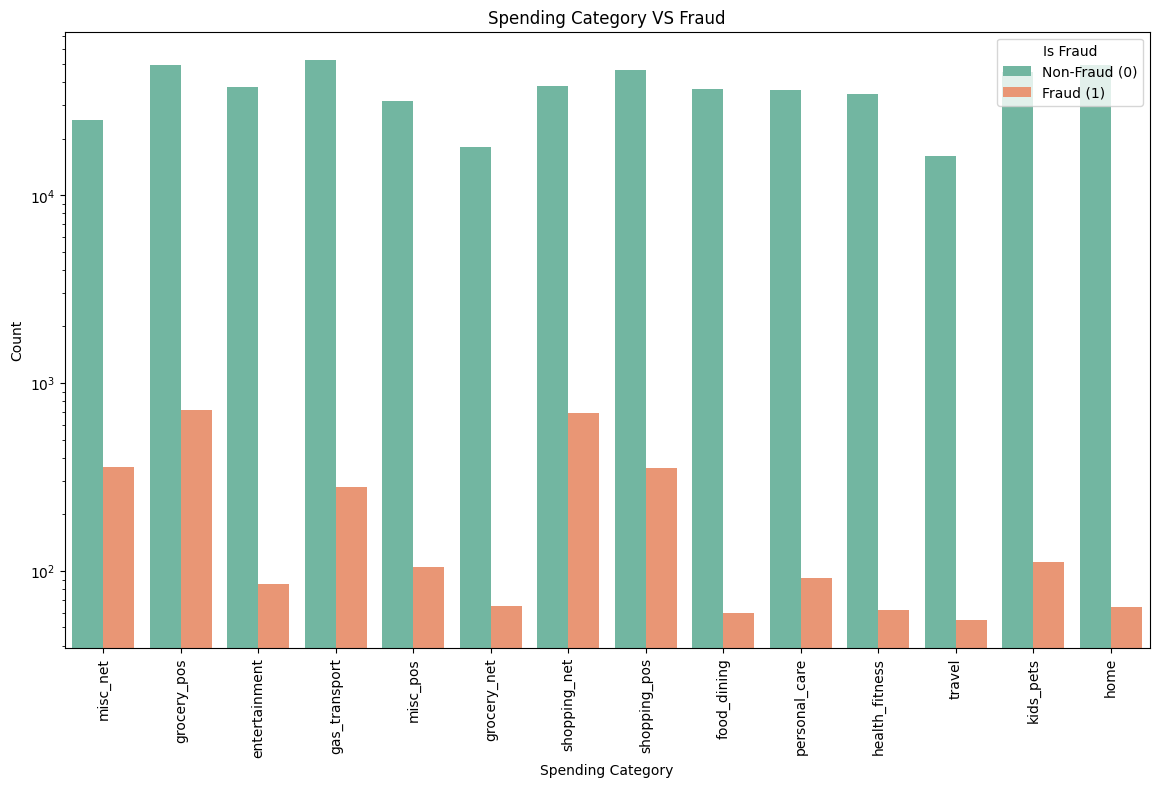

In [16]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=train_data, x='category', hue='is_fraud', palette='Set2')
plt.title('Spending Category VS Fraud')
plt.xlabel('Spending Category')
plt.ylabel('Count')
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.legend(title='Is Fraud', loc='upper right', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

Gender VS Fraud


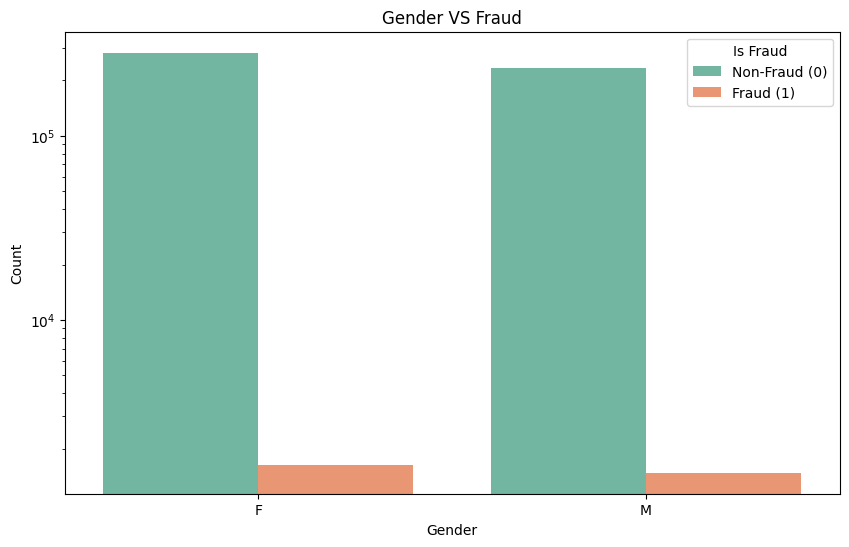

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_data, x='gender', hue='is_fraud', palette='Set2')
plt.title('Gender VS Fraud')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.legend(title='Is Fraud', loc='upper right', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

State VS Fraud


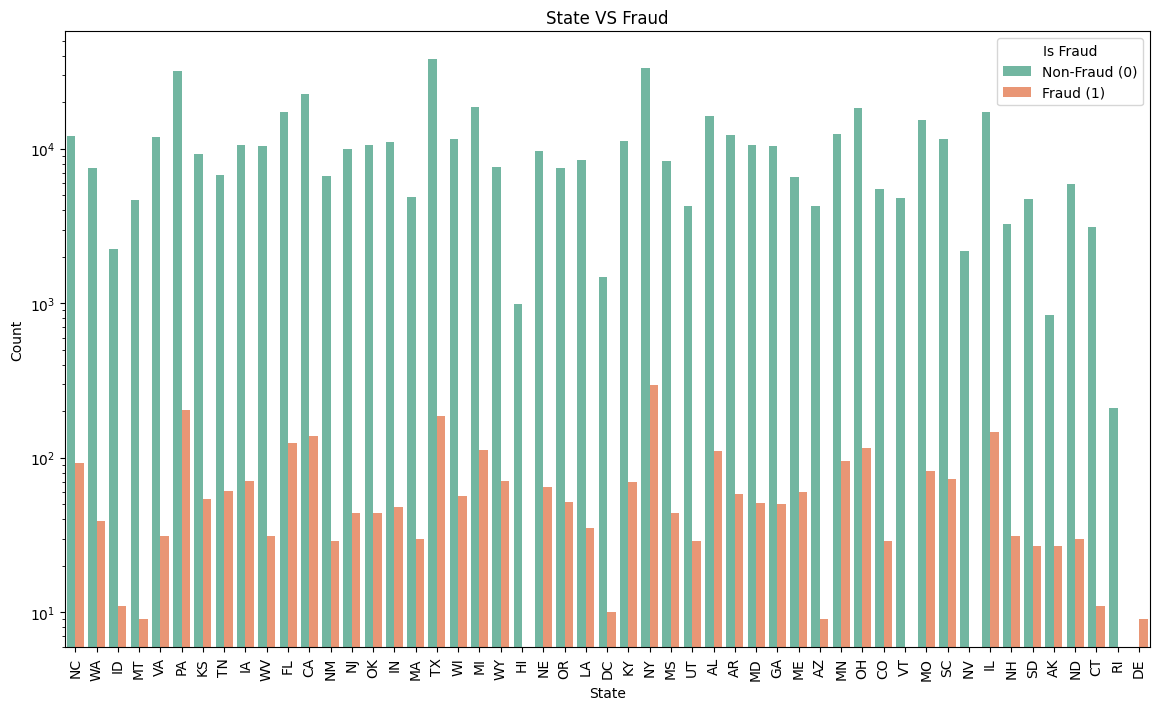

In [19]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=train_data, x='state', hue='is_fraud', palette='Set2')
plt.title('State VS Fraud')
plt.xlabel('State')
plt.ylabel('Count')
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.legend(title='Is Fraud', loc='upper right', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

City VS Fraud


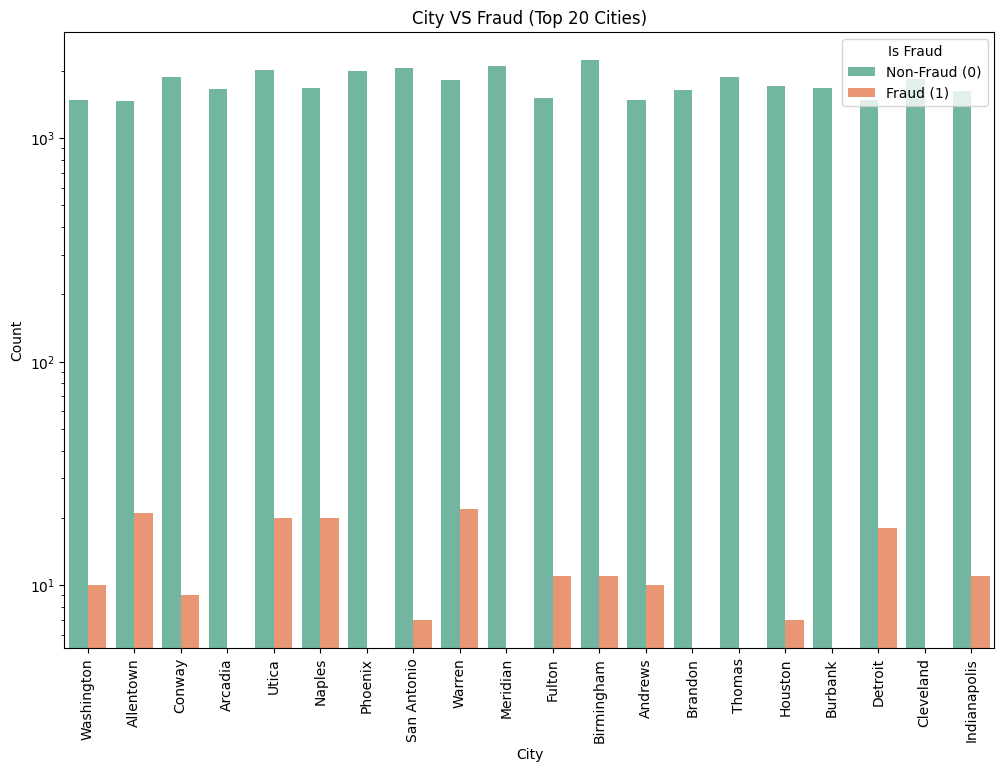

In [20]:
top_20_cities = train_data['city'].value_counts().nlargest(20).index
train_data_top_20 = train_data[train_data['city'].isin(top_20_cities)]

plt.figure(figsize=(12, 8))
sns.countplot(data=train_data_top_20, x='city', hue='is_fraud', palette='Set2')
plt.title('City VS Fraud (Top 20 Cities)')
plt.xlabel('City')
plt.ylabel('Count')
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.legend(title='Is Fraud', loc='upper right', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

Cyclicality of Credit Card Fraud


<ipython-input-22-ac5a46e01fa4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_by_hour, x='hour_of_day', y='is_fraud', palette='Set2')


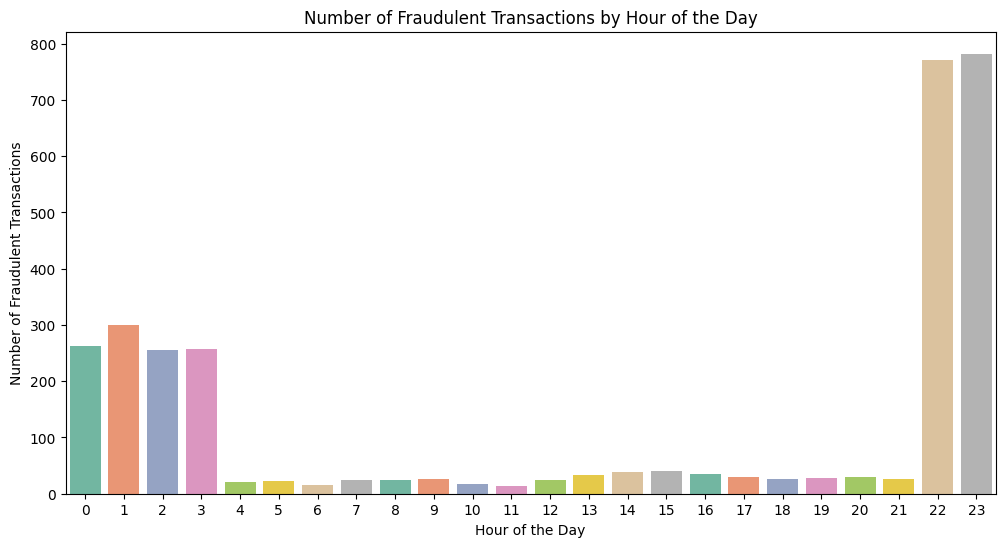

In [22]:
fraud_by_hour = train_data.groupby('hour_of_day')['is_fraud'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_hour, x='hour_of_day', y='is_fraud', palette='Set2')
plt.title('Number of Fraudulent Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

# 4. Train the Model


- Training: Configure and train a logistic regression model using the training data.


In [23]:
# Model training and evaluation
feature_cols = ['trans_num', 'hour_of_day', 'category', 'amt', 'merchant', 'job']
X = train_data[feature_cols].set_index("trans_num")
y = train_data['is_fraud']

In [24]:
# Encode categorical features
encoder = OrdinalEncoder(dtype=np.int64)
X.loc[:, ['category', 'merchant', 'job']] = encoder.fit_transform(X[['category', 'merchant', 'job']])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

- SMOTE: resolve imbalanced dataset

In [25]:
# Apply SMOTE to handle imbalanced data
smote = SMOTE(sampling_strategy={1: 48050}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train.astype('float'), y_train)

In [26]:
# Train the initial model
initial_rf_clf = RandomForestClassifier(max_features='sqrt', n_estimators=200, random_state=41)
initial_rf_clf.fit(X_train_smote, y_train_smote)

# Make initial predictions
y_pred_initial = initial_rf_clf.predict(X_test)


# 5. Evaluate the Model


In [27]:
# Print the initial classification report
print("Initial Model Classification Report:\n", classification_report(y_test, y_pred_initial))

Initial Model Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    103255
         1.0       0.75      0.77      0.76       621

    accuracy                           1.00    103876
   macro avg       0.87      0.88      0.88    103876
weighted avg       1.00      1.00      1.00    103876



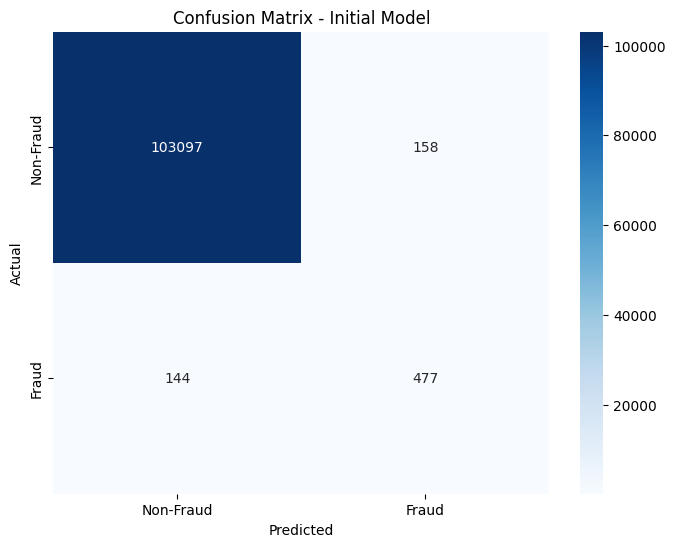

In [28]:
# Plot the confusion matrix for the initial model
conf_matrix_initial = confusion_matrix(y_test, y_pred_initial)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_initial, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Initial Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 6. Model Optimization and Tuning


Random Grid: Tune some Hyperparameters to find the best combination for Random Forest Classifier

In [29]:
# Random grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=30, stop=100, num=6)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(8, 40, num=8)] + [None],
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [2, 3, 5]
}

In [34]:
rf_clf = RandomForestClassifier(random_state=45)
rf_random_search = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_grid, n_iter=50, cv=3, verbose=2, random_state=38, n_jobs=-1)
rf_random_search.fit(X_train_smote, y_train_smote)

# Train the model with the best parameters
best_rf_clf = rf_random_search.best_estimator_
best_rf_clf.fit(X_train_smote, y_train_smote)

# Make predictions with the tuned model
y_pred_tuned = best_rf_clf.predict(X_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


# 7. Re-evaluate the Optimized Model


In [31]:
# Print the tuned model classification report
print("Tuned Model Classification Report:\n", classification_report(y_test, y_pred_tuned))

Tuned Model Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    103255
         1.0       0.74      0.78      0.76       621

    accuracy                           1.00    103876
   macro avg       0.87      0.89      0.88    103876
weighted avg       1.00      1.00      1.00    103876



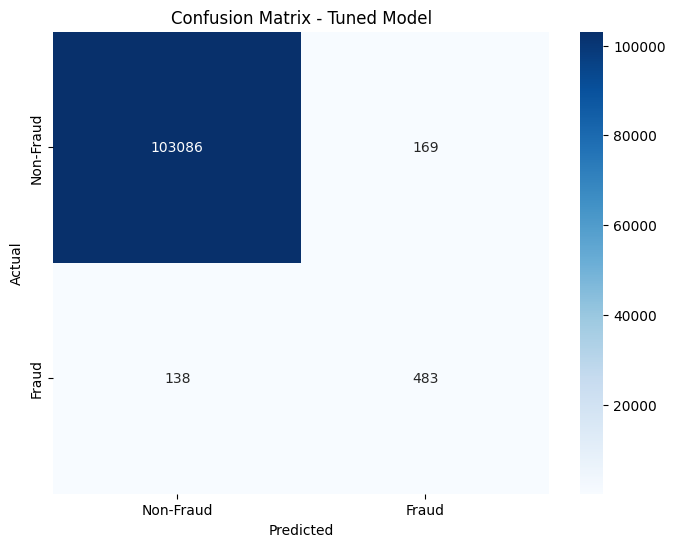

In [32]:
# Plot the confusion matrix for the tuned model
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Tuned Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()